# Зависимость рождаемости от брачности на основе анализа временных рядов

# 1) Визуальный анализ временных рядов


## 1.1 Подготовка данных по брачности

##### Импорт необходимых для дальнейшей работы библиотек

In [46]:
import pandas as pd # библиотека для работы с табличными данными;  Возможно понадобится установка openpyxl для чтения из excel
import matplotlib.pyplot as plt # библиотека для построения графиков
import matplotlib.ticker as ticker # модуль управления тиками
from statsmodels.graphics.tsaplots import plot_acf # АКФ
import statsmodels.api as sm # библиотека статистических функций 
import statsmodels
import datetime as dt # библиотека для работы с datetime
from math import sqrt

##### Загрузка данных из csv-файла в датафрейм pandas

In [2]:
df_marriage = pd.read_csv('divorce_marriage.csv', encoding='ansi')

##### Отображение структуры полученного датафрейма

In [3]:
df_marriage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28878 entries, 0 to 28877
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   territory               28878 non-null  int64  
 1   id_indicator            28878 non-null  int64  
 2   period                  28878 non-null  object 
 3   territory.ccube.0       28878 non-null  object 
 4   territory.ccube.1       28568 non-null  object 
 5   territory.ccube.2       26112 non-null  object 
 6   territory.ccube.attr.0  28878 non-null  int64  
 7   territory.ccube.3       28878 non-null  object 
 8   territory.ccube.4       28878 non-null  object 
 9   value                   28878 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.2+ MB


    - id_indicator - это id показателя (браки = 814, разводы = 816)
    - territory.ccube.(0-2) - это идентификатор уровня субъекта (0 - страна, 1 - федеральный округ, 2 - область или округ)
##### Выбор необходимого параметра и региона

In [4]:
df_m_clean = df_marriage.loc[(df_marriage['territory.ccube.3'] == 'Орловская область') & (df_marriage['id_indicator'] == 814)].reset_index(drop=True)

##### Удаление лишних колонок

In [5]:
df_m_clean = df_m_clean.drop(["territory", "id_indicator", "territory.ccube.0", "territory.ccube.1", "territory.ccube.2", "territory.ccube.attr.0", "territory.ccube.3", "territory.ccube.4"], axis=1)

##### Переименование колонок датафрейма

In [6]:
df_m_clean.rename(columns={'period': 'дата', 'value': 'значение'}, inplace=True)

##### Преобразование формата даты

In [7]:
format = '%d %b %Y %H:%M:%S' # задание исходного формата строки с датой

In [8]:
df_m_clean['дата'] = df_m_clean.apply(lambda x: dt.datetime.strptime(str(x['дата']), format), axis=1) # преобразование в datetime

In [9]:
new_format = '%d.%m.%Y' # задание того формата строки с датой, к которому нужно привести

In [10]:
df_m_clean['дата'] = df_m_clean.apply(lambda x: dt.datetime.strftime(x['дата'], new_format), axis=1) # преобразование в строку нужного формата 

##### Нормирование значений

In [11]:
min1 = df_m_clean['значение'].min() # определение min и max 
max1 = df_m_clean['значение'].max()

In [12]:
df_m_clean['норм_знач'] = df_m_clean.apply(lambda x: ((x['значение']-min1)/(max1-min1)), axis=1) # (x-min)/(max-min)

##### Отображение полученного датафрейма

In [13]:
df_m_clean

,дата,значение,норм_знач
0,31.01.2009,5.16,0.400000
1,28.02.2009,6.84,0.643478
2,31.03.2009,5.61,0.465217
3,30.04.2009,6.20,0.550725
4,31.05.2009,5.58,0.460870
...,...,...,...
150,31.08.2021,6.30,0.565217
151,30.09.2021,6.60,0.608696
152,31.10.2021,6.50,0.594203
153,30.11.2021,6.30,0.565217


## 1.2. Подготовка данных по рождаемости

##### Проделаем те жа шаги по подготовке данных и построению графика для данных по рождаемости

In [14]:
df_birth = pd.read_excel('birthrate.xlsx') # чтение данных из excel файла 

In [15]:
df_birth = df_birth.loc[df_birth['Субъект РФ'] == 'Орловская область'] # выбор нужного региона

In [16]:
df_birth.rename(columns={'Субъект РФ': ''}, inplace=True) # заранее переименовал колонку, которая будет датой 

In [17]:
df_birth = df_birth.set_index('').T # транспонирование таблицы

In [18]:
df_birth =  df_birth.reset_index() # создание колонки с индексом

In [19]:
df_birth.rename(columns={'index': 'дата', 'Орловская область': 'значение'}, inplace=True) # переименование колонки со значением по региону

In [20]:
format1 = '%Y-%m-%d %H:%M:%S' # исходный формат даты

In [21]:
df_birth['дата']= df_birth.apply(lambda y: dt.datetime.strptime(str(y['дата']), format1), axis=1) # в datetime

In [22]:
df_birth['дата'] = df_birth.apply(lambda x: dt.datetime.strftime(x['дата'], new_format), axis=1) # в нужный формат

In [23]:
min2 = df_birth['значение'].min() # min и max
max2 = df_birth['значение'].max()

In [24]:
df_birth['норм_знач'] = df_birth.apply(lambda x: ((x['значение']-min2)/(max2-min2)), axis=1) # нормирование

In [25]:
df_birth = df_birth.iloc[:155] # выбор части дф по рождаемости, чтобы он соотносился по количеству значений с дф по бракам

In [132]:
df_birth

,дата,значение,норм_знач
0,01.01.2009,9.6,0.604167
1,01.02.2009,10.1,0.708333
2,01.03.2009,10.3,0.750000
3,01.04.2009,10.4,0.770833
4,01.05.2009,10.1,0.708333
...,...,...,...
150,01.07.2021,7.4,0.145833
151,01.08.2021,7.5,0.166667
152,01.09.2021,7.5,0.166667
153,01.10.2021,7.5,0.166667


## 1.3 Построение обобщенного графика для брачности и рождаемости

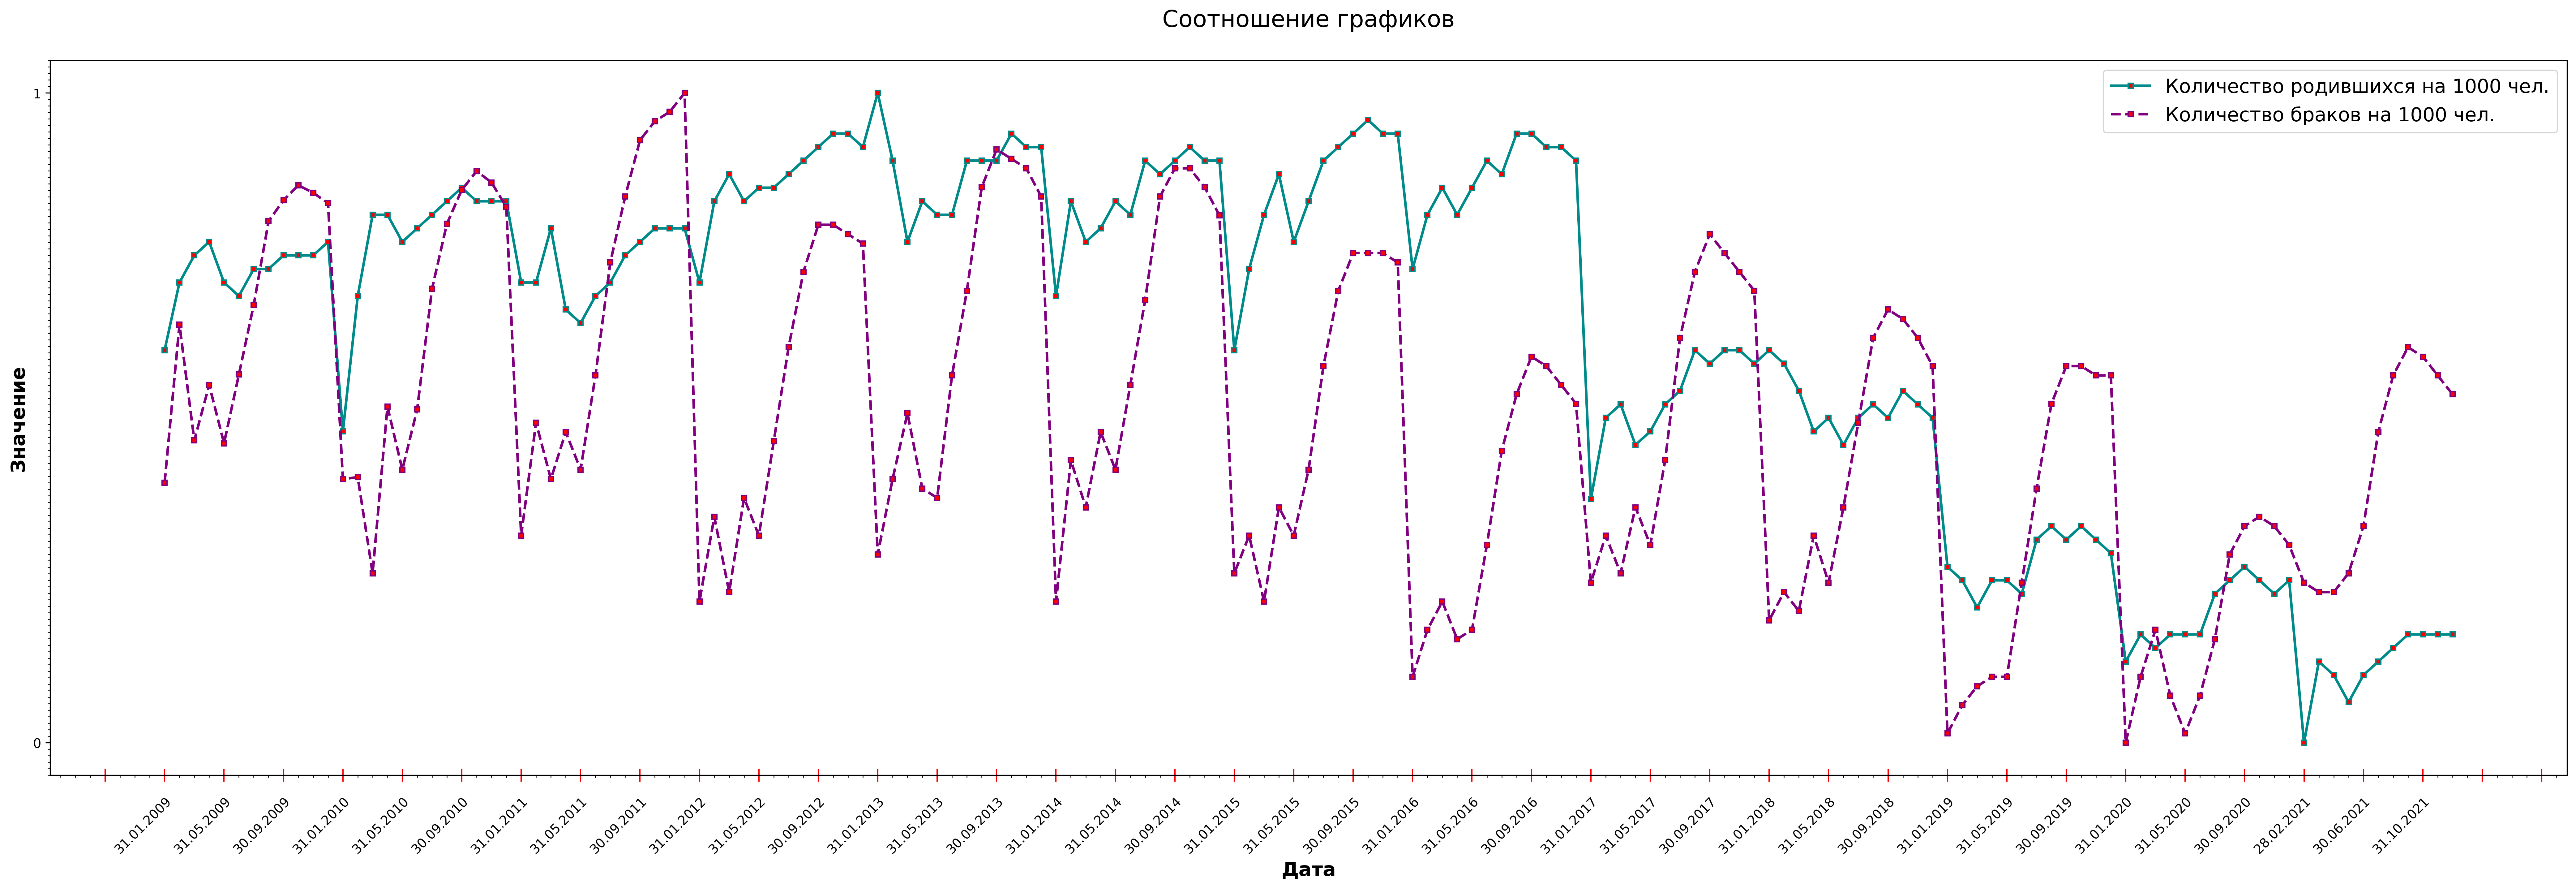

In [27]:
fig, ax = plt.subplots(dpi=300)

x = df_m_clean['дата']
y = df_birth['норм_знач']

ax.plot(x, y, color='darkcyan', lw=2, ls='-', marker='s', markersize=4, markerfacecolor='red', label='Количество родившихся на 1000 чел.')

y1 = df_m_clean['норм_знач']

ax.plot(x, y1, color='purple', lw=2, ls='--', marker='s', markersize=4, markerfacecolor='red', label='Количество браков на 1000 чел.')

#  Исправление формата подписей оси x
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.legend(loc=0, prop={'size': 15})
ax.set_xlabel('Дата', fontsize=15, fontweight='bold')
ax.set_ylabel('Значение', fontsize=15, fontweight='bold')
ax.set_title('Соотношение графиков\n',
            fontsize=18)

ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 1,     #  Ширина делений
               color = 'r',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'k',    #  Цвет подписи
               bottom = True,    #  Рисуем метки снизу
               labelbottom = True)    #  Рисуем подписи снизу

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.set_figwidth(35)
fig.set_figheight(10)

plt.show()

## 1.4 Построение графика АКФ

Доверительные интервалы для АКФ в библиотеке рассчитываются для тех лагов, для которых рассчитана формула Бартлетта

### 1.4.1. АКФ и ЧАКФ для временного ряда по брачности

In [28]:
leftcr = -1.96/sqrt(df_m_clean.shape[0])
rightcr = 1.96/sqrt(df_m_clean.shape[0])

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


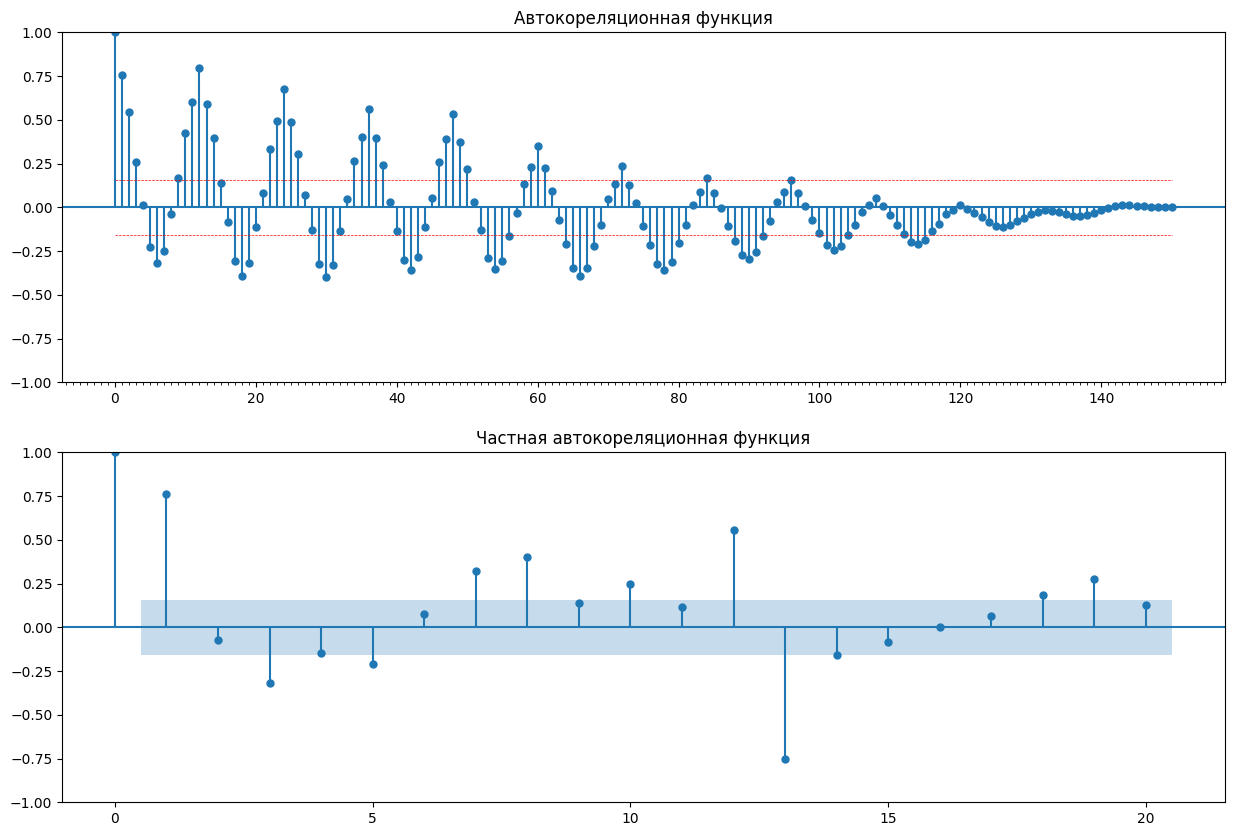

In [29]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig = sm.graphics.tsa.plot_acf(df_m_clean['значение'], lags=150, ax=ax, alpha=None, title='Автокореляционная функция')
ax.hlines(leftcr, 0, 150,
          color = 'red',
          linewidth = 0.5,
          linestyle = '--')
ax.hlines(rightcr, 0, 150,
          color = 'red',
          linewidth = 0.5,
          linestyle = '--')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_m_clean['значение'], lags=20, ax=ax2, title='Частная автокореляционная функция')

##### Каждые 12 лагов достигается максимальное значение АКФ, что говорит о наличии сезонности; 

In [30]:
acf_array = sm.tsa.stattools.acf(df_m_clean['значение'], nlags=40, fft=False)

In [31]:
acf_df = pd.DataFrame(acf_array, columns = ['АКФ'])

In [32]:
acf_df.head(13).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
АКФ,1.0,0.756942,0.543984,0.258659,0.015323,-0.224296,-0.320759,-0.252316,-0.039436,0.168332,0.426398,0.601737,0.794407


### 1.4.1. АКФ и ЧАКФ для временного ряда по рождаемости

In [33]:
leftcr = -1.96/sqrt(df_birth.shape[0])
rightcr = 1.96/sqrt(df_birth.shape[0])

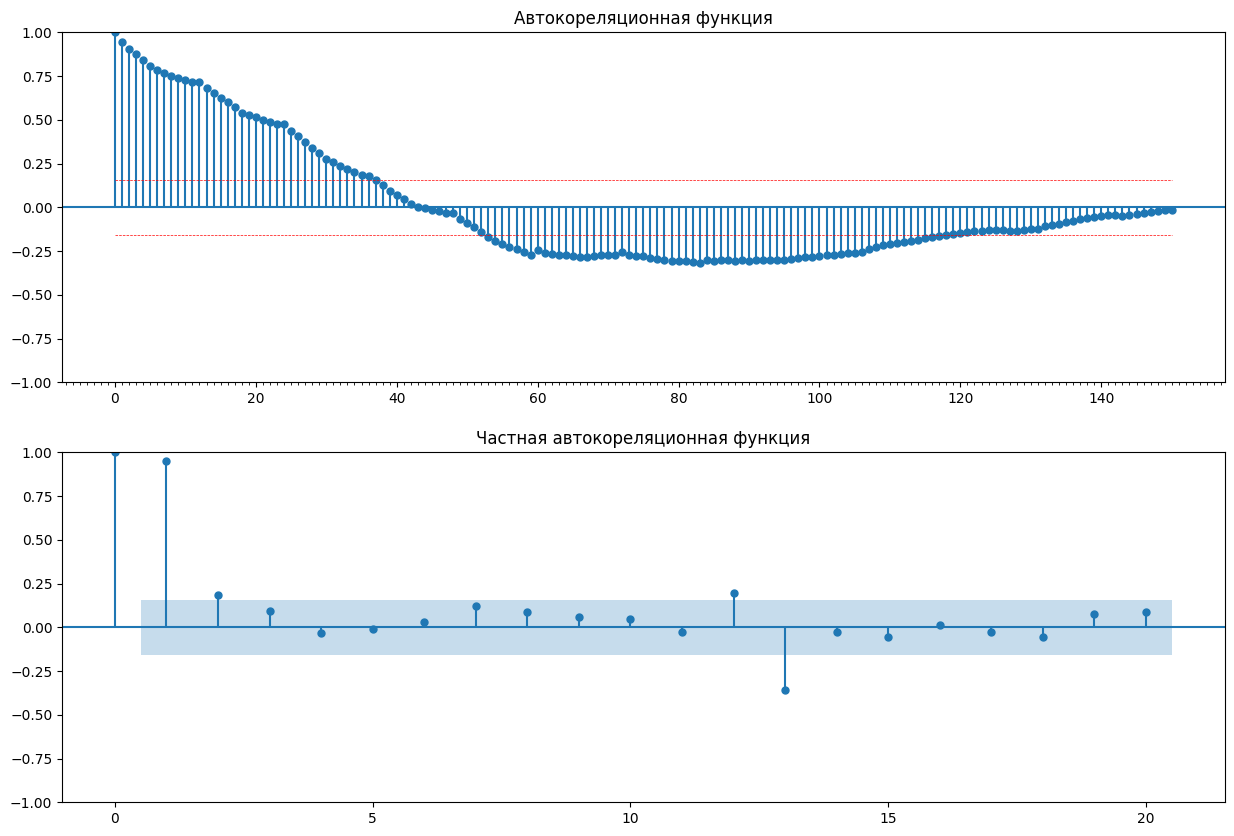

In [121]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig = sm.graphics.tsa.plot_acf(df_birth['значение'], lags=150, ax=ax, alpha=None, title='Автокореляционная функция')
ax.hlines(leftcr, 0, 150,
          color = 'red',
          linewidth = 0.5,
          linestyle = '--')
ax.hlines(rightcr, 0, 150,
          color = 'red',
          linewidth = 0.5,
          linestyle = '--')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_birth['значение'], lags=20, ax=ax2, title='Частная автокореляционная функция')

# 2) Расширенный тест Дики-Фуллера

## 2.1. Тест для временного ряда по брачности

###### H0: Есть единичный корень - ряд стационарен
###### H1: Единичного корня нет - ряд не стационарен

Количество лагов вычисляется по информационному критерию Акаике (AIC). Можно вычислить их также по информационному критерию Байеса (BIC) или по значению t-статистики. Формула для вычисления по AIC: 12*(nobs/100)^{1/4}

In [35]:
test = sm.tsa.stattools.adfuller(df_m_clean['значение'], regression='ct', autolag='AIC')
print('Значение t-статистики: '+str(test[0]))
print('Значение p-уровня: '+str(test[1]))
print('Количество лагов в регресионном уравнении: '+str(test[2]))
print('Количество значений, используемое при построении модели: '+str(test[3]))
print('Критические значения: '+str(test[4]))

Значение t-статистики: -3.894691478868645
Значение p-уровня: 0.012338245593235151
Количество лагов в регресионном уравнении: 14
Количество значений, используемое при построении модели: 140
Критические значения: {'1%': -4.024934298469388, '5%': -3.4423275561224487, '10%': -3.1457269825072887}


## 2.1. Тест для временного ряда по рождаемости

In [41]:
test = sm.tsa.stattools.adfuller(df_birth['значение'], regression='n', autolag='AIC')
print('Значение t-статистики: '+str(test[0]))
print('Значение p-уровня: '+str(test[1]))
print('Количество лагов в регресионном уравнении: '+str(test[2]))
print('Количество значений, используемое при построении модели: '+str(test[3]))
print('Критические значения: '+str(test[4]))

Значение t-статистики: -0.9979250626221766
Значение p-уровня: 0.2889382378710962
Количество лагов в регресионном уравнении: 12
Количество значений, используемое при построении модели: 142
Критические значения: {'1%': -2.581664945447332, '5%': -1.9430475262704974, '10%': -1.6150753154275783}


##### На основе анализа графиков временных рядов рождаемости и брачности, графиков их АКФ и ЧАКФ можно сдлеать следующие выводы:
##### Вр. р. брачности имеет сезонность (12 месяцев), слабовыраженный тренд, параметр AC (p) = 2 и параметр d = 1.
##### Вр. р. рождаемости не имеет сезонности, имеет параметр AC (p) = 2 и параметр d = 1.
##### Параметр MA (q)  отсутствует

# 3) Построение модели авторегрессии AR(2) для вр. р. по рождаемости

In [122]:
AR_model = sm.tsa.ARIMA(df_birth['значение'], order=(2, 1, 0)).fit()

In [123]:
AR_prediction = AR_model.predict(130, 160)

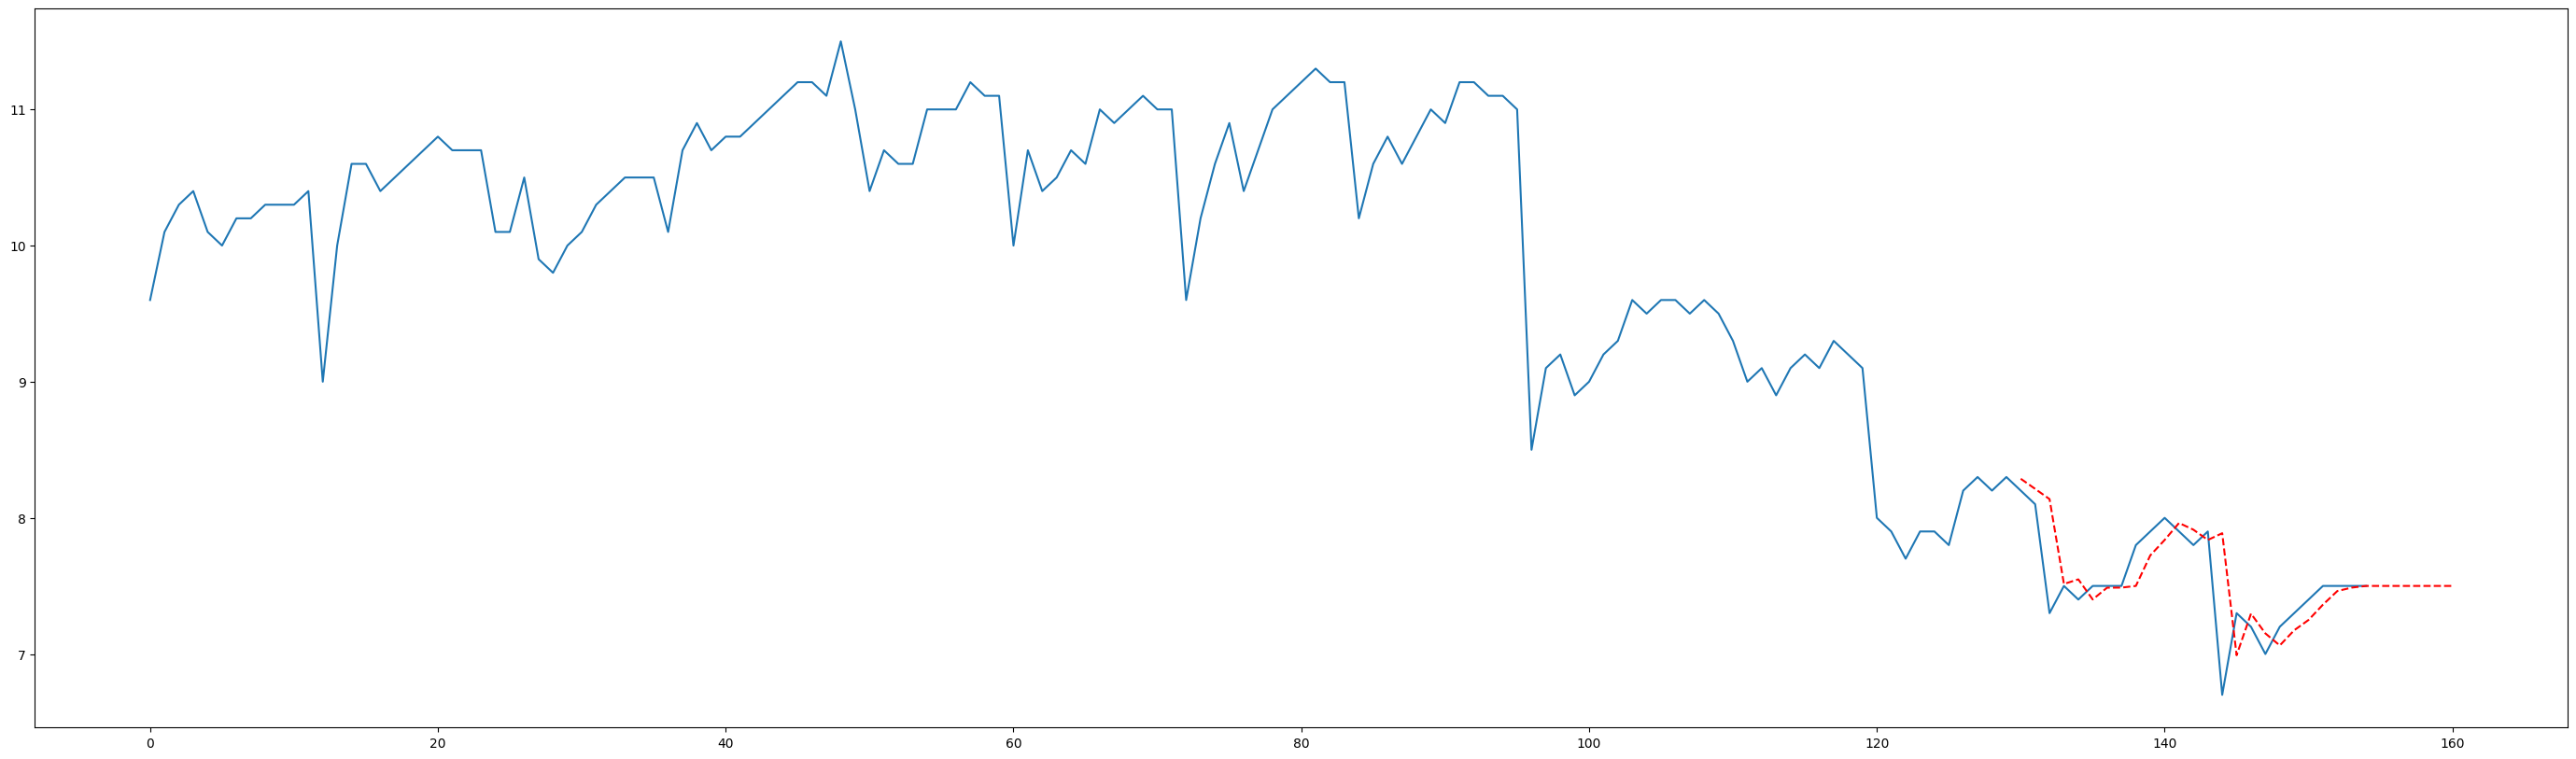

In [124]:
fig = df_birth['значение'].plot(figsize=(35,10))
ax = AR_prediction.plot(style='r--')

##### TODO: Проверить по метрикам качество прогноза в модели

# 4) Построение модели ARDL с учетом влияния брачности со смещением лага

In [183]:
y = df_birth['норм_знач'].iloc[:130]

In [184]:
x = df_m_clean['норм_знач'].iloc[:130]

In [185]:
x = sm.add_constant(x)

In [221]:
ARDLM = statsmodels.tsa.ardl.ARDL(y, 2, x, 2).fit()

In [222]:
c = df_m_clean['норм_знач'].iloc[130:]

In [223]:
c = sm.add_constant(c)

In [224]:
ardlm_pred = ARDLM.predict(start = 130,end = 154, exog_oos = c)

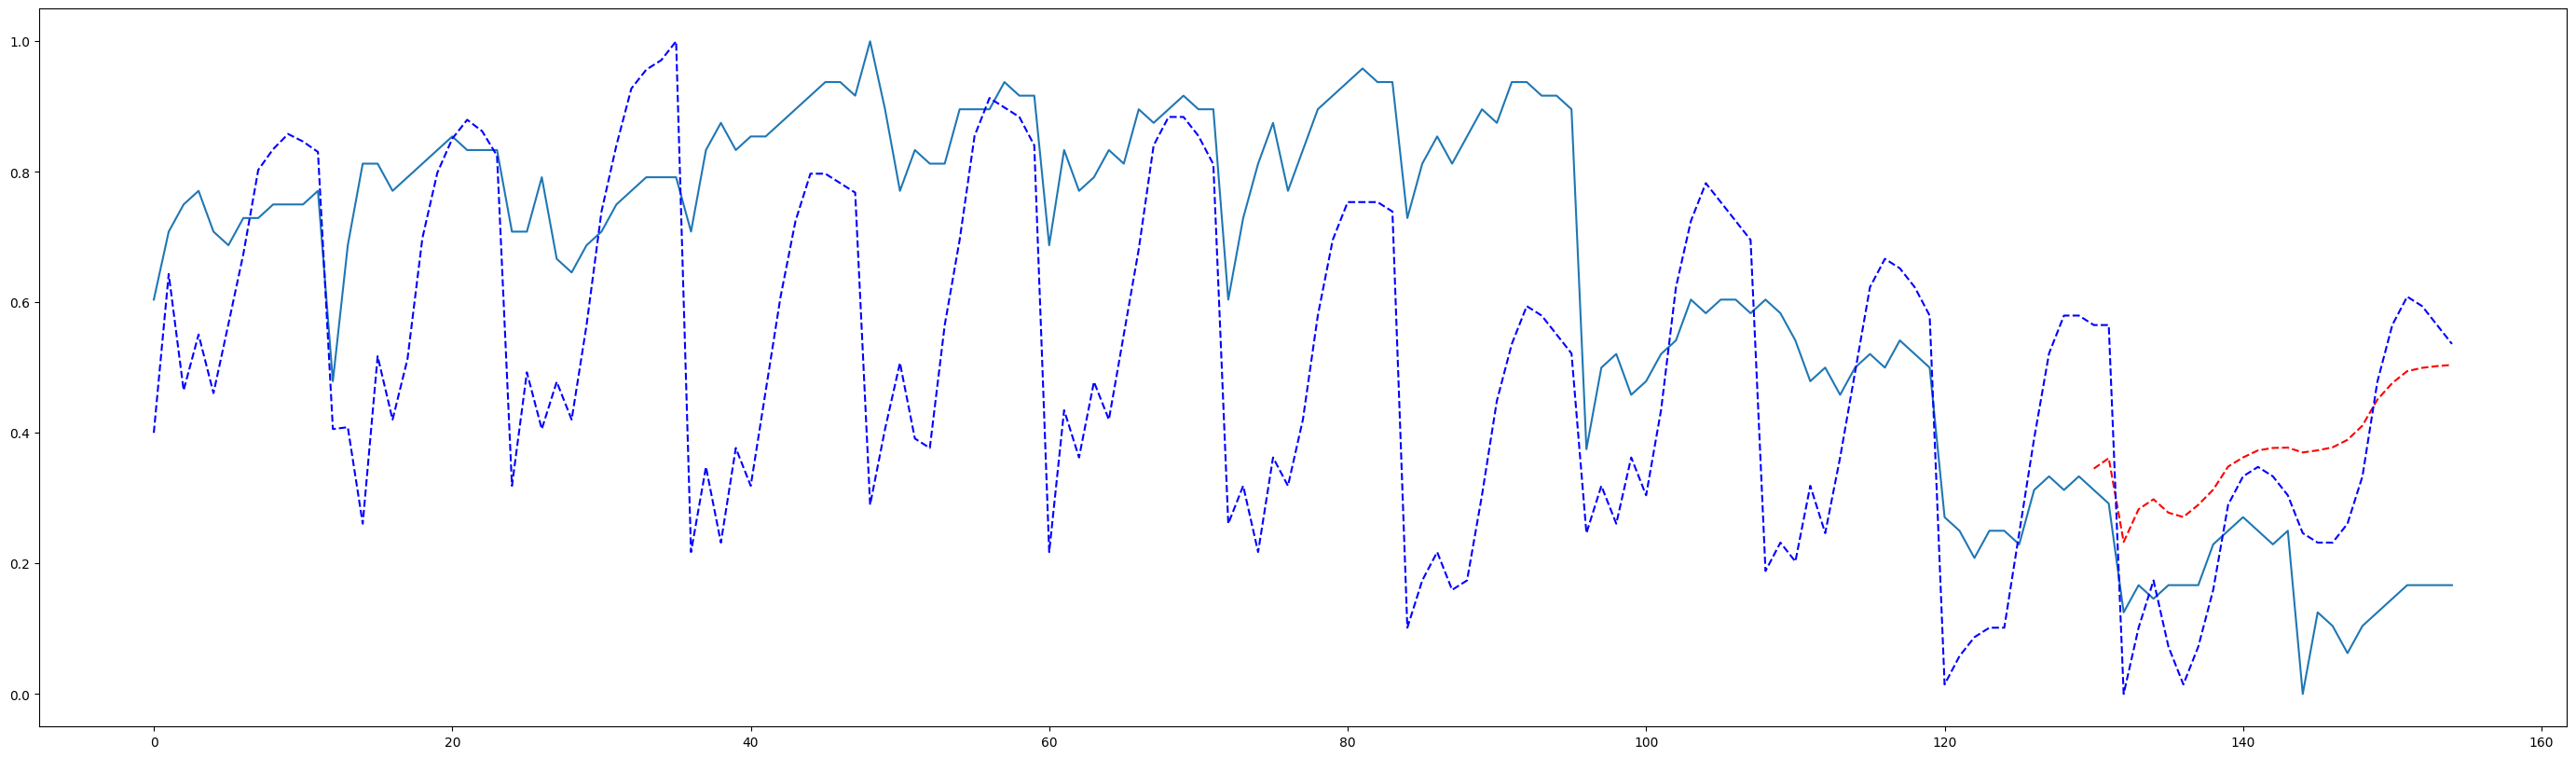

In [225]:
fig = df_birth['норм_знач'].plot(figsize=(35,10))
ax = ardlm_pred.plot(style='r--')
ax = df_m_clean['норм_знач'].plot(style='b--')